Name :HE YUNFAN


E-mail : wjshyf@gmail.com

# Useful Jupyter Notebook Shortcuts

Here are some helpful keyboard shortcuts for Jupyter Notebook:

- **M**: Switch to Markdown mode
- **Y**: Switch to Code mode
- **A**: Insert cell above
- **B**: Insert cell below
- **D, D**: (Press D twice) Delete selected cell
- **Shift + Enter**: Run the current cell and move to the next
- **Ctrl + Enter**: Run the current cell and stay on it
- **Shift + Tab**: Show function/method documentation
- **Ctrl + Shift + -**: Split cell at cursor
- **Esc**: Enter command mode (blue border)
- **Enter**: Enter edit mode (green border)


## default imports

In [13]:
# import for internal use
from urllib.error import URLError
from tensorflow.data import Dataset
import os
from pathlib import Path
import tensorflow as tf
from keras.utils import image_dataset_from_directory, get_file

In [14]:
# general imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# data analysis import
from skimage import io, img_as_float
from scipy import stats
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

In [16]:
# machine learning imports
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, Conv1D, Conv2D, UpSampling2D, MaxPooling2D, AveragePooling2D, Rescaling, Activation, Add, Flatten, Reshape
from keras.models import Sequential, Model
from keras import optimizers, regularizers
from sklearn.metrics import r2_score, mean_absolute_percentage_error



## internal functions

In [17]:
from typing import Union
import tensorflow as tf

def transpose_image_grayscale(image: tf.Tensor) -> tf.Tensor:
    """
    Transpose a grayscale image from portrait to landscape orientation if necessary.

    This function checks the dimensions of the input image and transposes it if
    the height (first dimension) is less than the width (second dimension).
    The transposition ensures the image is always in landscape orientation.

    Parameters
    ----------
    image : tf.Tensor
        A 3D tensor representing a grayscale image with shape (height, width, 1).
        The last dimension represents the single color channel.

    Returns
    -------
    tf.Tensor
        A 3D tensor with the same content as the input image, but guaranteed to be
        in landscape orientation (width >= height).

    Notes
    -----
    The function assumes the input is a valid TensorFlow tensor representing
    a grayscale image with three dimensions (height, width, channel).

    Examples
    --------
    >>> import tensorflow as tf
    >>> # Create a portrait grayscale image (5x3x1)
    >>> portrait_image = tf.random.normal([5, 3, 1])
    >>> landscape_result = transpose_image_grayscale(portrait_image)
    >>> print(tf.shape(landscape_result).numpy())
    [3 5 1]

    >>> # Create a landscape grayscale image (3x5x1)
    >>> landscape_image = tf.random.normal([3, 5, 1])
    >>> result = transpose_image_grayscale(landscape_image)
    >>> print(tf.shape(result).numpy())
    [3 5 1]

    See Also
    --------
    tf.transpose : The underlying TensorFlow operation used for transposition.

    Raises
    ------
    ValueError
        If the input tensor does not have exactly 3 dimensions.
    """
    # Check if image is in portrait mode
    if tf.shape(image)[0] < tf.shape(image)[1]:
        # Transpose to landscape mode
        return tf.transpose(image, perm=[1, 0, 2])  # No need for channel dim in grayscale
    else:
        # If it's already landscape, return the image as is
        return image

## Public Functions

In [18]:
def load_and_create_datasets(
    url: str,
    fname: str,
    batch_size: int = 16,
    image_size: tuple[int, int] = (480, 320)
) -> tuple[Dataset, Dataset]:
    """
    Load and prepare image datasets for denoising tasks.

    This function downloads a dataset, extracts it, and creates TensorFlow datasets
    for training and testing. It handles both original (clean) and noisy images,
    applying necessary preprocessing steps including transposition and normalization.

    Parameters
    ----------
    url : str
        URL or local path to the dataset zip file.
    fname : str
        Filename to save the downloaded dataset.
    batch_size : int, optional
        Batch size for the datasets, by default 16.
    image_size : tuple of int, optional
        Target size for the images (height, width), by default (480, 320).

    Returns
    -------
    Tuple[Dataset, Dataset]
        A tuple containing:
        - dataset_train: A TensorFlow Dataset containing pairs of (noisy, original) images for training
        - dataset_test: A TensorFlow Dataset containing pairs of (noisy, original) images for testing

    Notes
    -----
    The function performs several steps:
    1. Downloads and extracts the dataset
    2. Creates separate datasets for original and noisy images, both for training and testing
    3. Applies image transposition to ensure consistent orientation
    4. Normalizes pixel values from [0, 255] to [0, 1]

    The expected dataset structure after extraction is:
    - BSD400/original/ (training original images)
    - BSD400/noise_gaussian_15/ (training noisy images)
    - BSD68/original/ (testing original images)
    - BSD68/noise_gaussian_15/ (testing noisy images)

    Examples
    --------
    >>> url = "https://example.com/dataset.zip"
    >>> fname = "denoising_dataset.zip"
    >>> train_ds, test_ds = load_and_create_datasets(url, fname)
    >>> for noisy_batch, clean_batch in train_ds.take(1):
    ...     print(f"Batch shape: {noisy_batch.shape}")

    Raises
    ------
    Exception
        If the URL download fails, it attempts to use the URL as a local filename.

    Notes
    -----
    - All images are loaded in grayscale mode
    - Images are automatically transposed if needed using the transpose_image_grayscale function
    - Pixel values are rescaled from 0-255 to 0-1
    - The function uses a specific file hash for verification

    See Also
    --------
    transpose_image_grayscale : Function used for ensuring consistent image orientation
    tensorflow.keras.utils.get_file : Used for downloading and extracting the dataset
    """
    image_size = tuple(image_size[0:2])
    dset_name = Path(fname).stem

    FileHash = r"d68e70fa5e9ba1ae4d36dd40a0095f1e1bb49d6574c0372eb5079c636fce0651"

    try:
        dset_download = get_file(fname=fname,
            origin=url,
            extract=True,
            file_hash=FileHash,
            archive_format="zip",
            force_download=False
        )
    except Exception:
            print("URL download failed, try using DATASET_URL as a local filename")
            dset_download = get_file(fname=fname,
                                          origin  = "file:\\"+url,
            extract=True,
            file_hash=FileHash,
            archive_format="zip",
            force_download=False
        )


    # Step 2: Get the path of the extracted directory
    dataset_dir = os.path.dirname(dset_download)
    image_dataset_from_directory_common_args = {
        "label_mode":None,
        "class_names":None,
        "color_mode":"grayscale",
        "batch_size":batch_size,
        "image_size":image_size,
        "shuffle":False,
        "seed":42,
        "validation_split":None,
        "subset":None,
        "interpolation":"bilinear",
        "follow_links":False,
        "crop_to_aspect_ratio":False,
        "pad_to_aspect_ratio":False,
        "data_format":None,
        "verbose":False,
    }

    train_images_original = image_dataset_from_directory(
        Path(dataset_dir).joinpath(dset_name+"_extracted",dset_name, "BSD400","original"),
        **image_dataset_from_directory_common_args
    )

    train_images_noisy = image_dataset_from_directory(
        Path(dataset_dir).joinpath(dset_name+"_extracted",dset_name, "BSD400","noise_gaussian_15"),
        **image_dataset_from_directory_common_args
    )

    test_images_original = image_dataset_from_directory(
        Path(dataset_dir).joinpath(dset_name+"_extracted",dset_name, "BSD68", "original"),
        **image_dataset_from_directory_common_args
    )

    test_images_noisy = image_dataset_from_directory(
        Path(dataset_dir).joinpath(dset_name+"_extracted",dset_name, "BSD68", "noise_gaussian_15"),
        **image_dataset_from_directory_common_args
    )



    # Apply the transpose function for grayscale images
    train_images_original = train_images_original.map(lambda x: tf.map_fn(transpose_image_grayscale, x))
    test_images_original = test_images_original.map(lambda x: tf.map_fn(transpose_image_grayscale, x))
    train_images_noisy = train_images_noisy.map(lambda x: tf.map_fn(transpose_image_grayscale, x))
    test_images_noisy = test_images_noisy.map(lambda x: tf.map_fn(transpose_image_grayscale, x))


    rescale = Rescaling(1.0 / 255)

    # Apply the Rescaling layer for normalization to both datasets
    train_images_original = train_images_original.map(lambda x: rescale(x))
    test_images_original = test_images_original.map(lambda x: rescale(x))
    train_images_noisy = train_images_noisy.map(lambda x: rescale(x))
    test_images_noisy = test_images_noisy.map(lambda x: rescale(x))


    dataset_train = Dataset.zip((train_images_noisy, train_images_original))
    dataset_test = Dataset.zip((test_images_noisy, test_images_original))
    print("Datasets for train and test, created. Please note that pixels values have been rescale from 0->255 to 0->1")
    return dataset_train, dataset_test

In [19]:
def dataset_to_list(dataset):
    flat_images_noisy = []
    flat_images_original = []

    for noisy_batch, original_batch in dataset:
        # Convert to numpy and flatten the batch dimension
        noisy_images = noisy_batch.numpy()
        original_images = original_batch.numpy()

        # Extend our lists with the flattened batches
        flat_images_noisy.extend(noisy_images)
        flat_images_original.extend(original_images)

    return tuple([x.squeeze() for x in flat_images_noisy]), tuple([x.squeeze() for x in flat_images_original])

In [20]:
   def fourier_denoise(image, threshold=0.1):
       # Compute the 2D FFT of the image
       f = np.fft.fft2(image)

       # Shift the zero-frequency component to the center
       f_shift = np.fft.fftshift(f)

       # Create a mask based on the threshold
       mask = np.abs(f_shift) > threshold * np.max(np.abs(f_shift))

       # Apply the mask
       f_shift_filtered = f_shift * mask

       # Shift back
       f_filtered = np.fft.ifftshift(f_shift_filtered)

       # Compute the inverse 2D FFT
       denoised = np.real(np.fft.ifft2(f_filtered))

       return np.clip(denoised, 0., 1.), f_shift, f_shift_filtered

## global variables

In [21]:
DATASET_URL = "https://amubox.univ-amu.fr/s/TP3mLFKikYdxt7o/download/dataset_bsd400_68.zip"
DATASET_FNAME = "dataset_bsd400_68.zip"
# images downsampled to reduce memory usage during training
IMAGE_SHAPE = (240, 160, 1) # last value correspond to the number of channels : 1 for grayscale, 3 for rgb

# Dataset Loading

In [22]:
dataset_train, dataset_test = load_and_create_datasets(DATASET_URL, DATASET_FNAME, image_size=IMAGE_SHAPE)

Datasets for train and test, created. Please note that pixels values have been rescale from 0->255 to 0->1


In [23]:
!ls /root/.keras/datasets/dataset_bsd400_68_extracted

dataset_bsd400_68


In [24]:
images_noise_test, images_ref_test = dataset_to_list(dataset_test)
images_noise_train, images_ref_train = dataset_to_list(dataset_train)

## Dataset Analysis

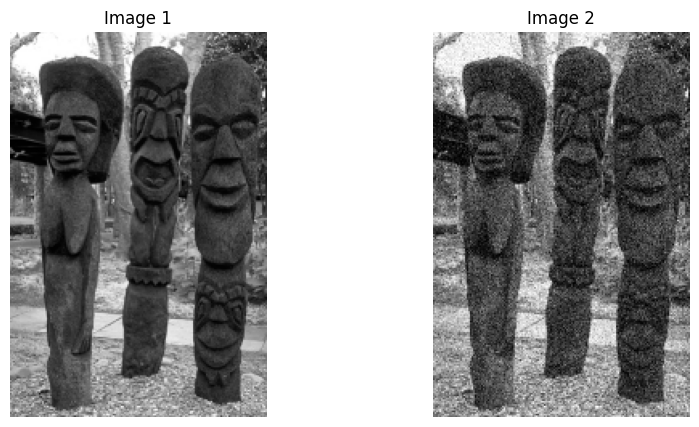

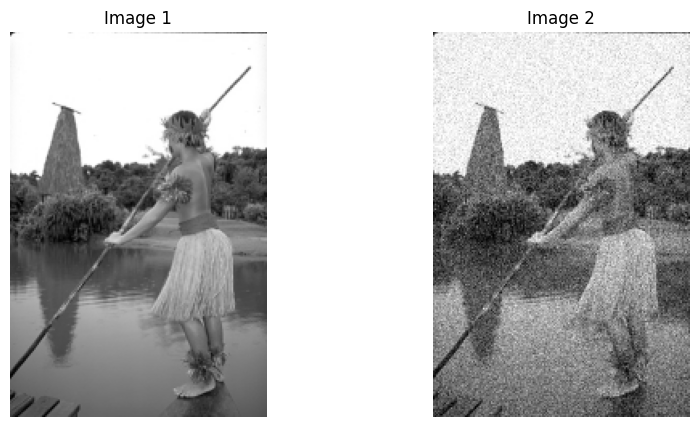

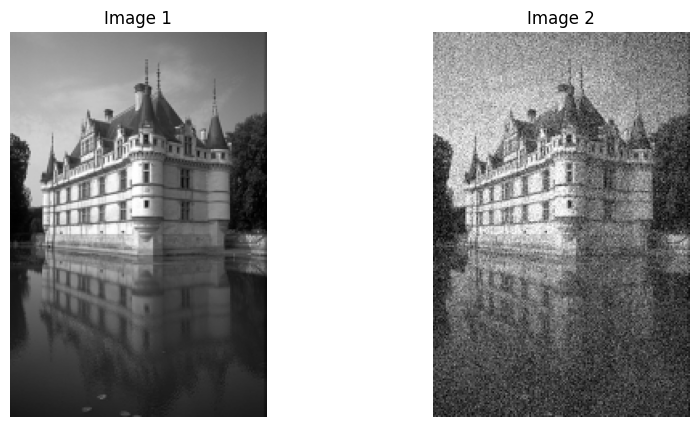

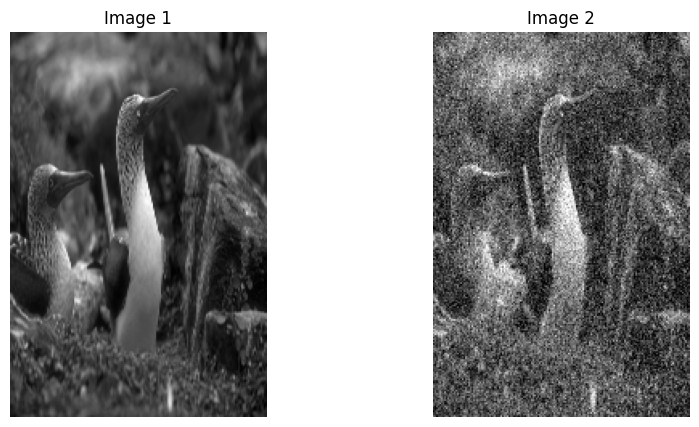

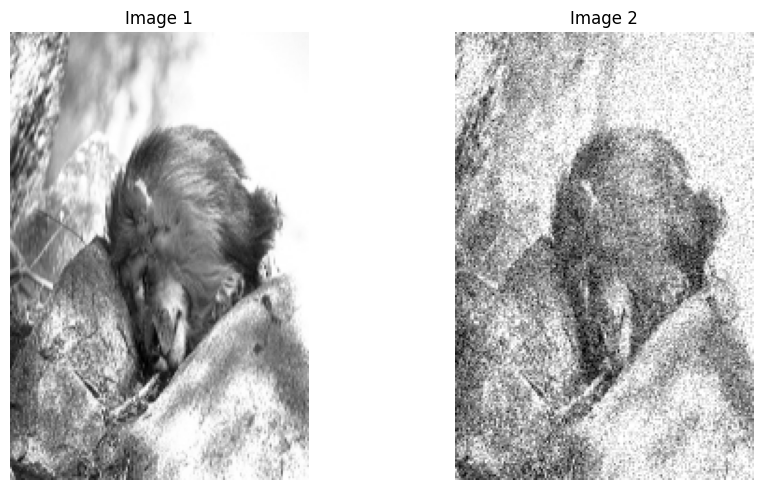

In [32]:
for i in range(5):


  fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Show first image
  axes[0].imshow(images_ref_test[i],cmap='grey')
  axes[0].axis('off')
  axes[0].set_title("Image 1")

# Show second image
  axes[1].imshow(images_noise_test[i],cmap='grey')
  axes[1].axis('off')
  axes[1].set_title("Image 2")

plt.tight_layout()  # adjust spacing
plt.show()


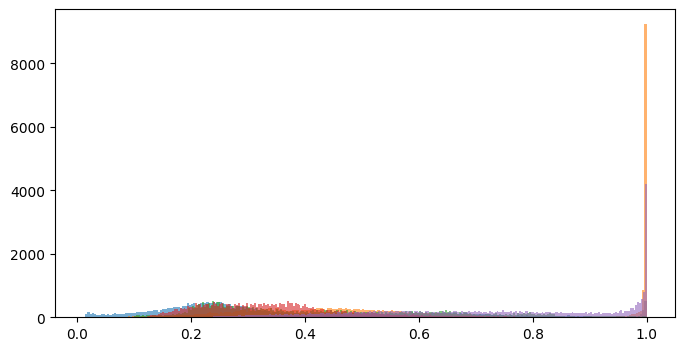

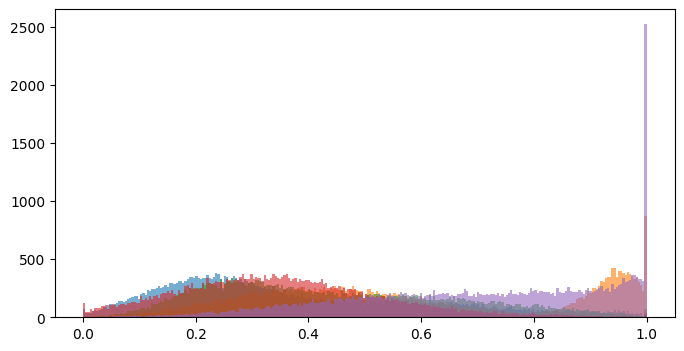

In [49]:
plt.figure(figsize=(8, 4))
for i in range(5):
  plt.hist(images_ref_test[i].flatten(),bins=256,alpha=0.6)

plt.figure(figsize=(8, 4))
for i in range(5):
   plt.hist(images_noise_test[i].flatten(),bins=256,alpha=0.6)

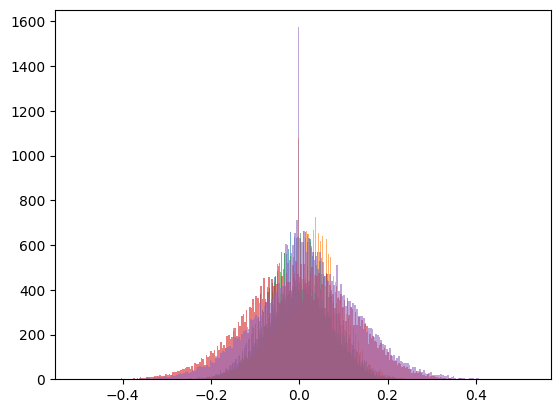

In [50]:
diff_pixel = np.zeros((5,240,160))
for i in range(5):
  diff_pixel[i] = images_ref_test[i] - images_noise_test[i]
  plt.hist(diff_pixel[i].flatten(),bins=256,alpha=0.6)

In [52]:
from skimage.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

# Initialize lists to store metrics
mse_scores = []
mae_scores = []
psnr_scores = []
ssim_scores = []

# Calculate metrics for the first 5 image pairs and store them
for i in range(5):
    ref_image = images_ref_test[i]
    noisy_image = images_noise_test[i]

    mse_score = mse(ref_image, noisy_image)
    mae_score = mae(ref_image.flatten(), noisy_image.flatten())
    psnr_score = psnr(ref_image, noisy_image, data_range=noisy_image.max() - noisy_image.min())
    ssim_score = ssim(ref_image, noisy_image, data_range=noisy_image.max() - noisy_image.min())

    mse_scores.append(mse_score)
    mae_scores.append(mae_score)
    psnr_scores.append(psnr_score)
    ssim_scores.append(ssim_score)

    print(f"Metrics for image pair {i+1}:")
    print(f"  MSE: {mse_score:.4f}")
    print(f"  MAE: {mae_score:.4f}")
    print(f"  PSNR: {psnr_score:.4f}")
    print(f"  SSIM: {ssim_score:.4f}")
    print("-" * 20)

Metrics for image pair 1:
  MSE: 0.0051
  MAE: 0.0568
  PSNR: 22.9358
  SSIM: 0.6715
--------------------
Metrics for image pair 2:
  MSE: 0.0055
  MAE: 0.0592
  PSNR: 22.6328
  SSIM: 0.4726
--------------------
Metrics for image pair 3:
  MSE: 0.0053
  MAE: 0.0579
  PSNR: 22.7946
  SSIM: 0.4435
--------------------
Metrics for image pair 4:
  MSE: 0.0137
  MAE: 0.0937
  PSNR: 18.6432
  SSIM: 0.3532
--------------------
Metrics for image pair 5:
  MSE: 0.0125
  MAE: 0.0860
  PSNR: 19.0261
  SSIM: 0.4464
--------------------


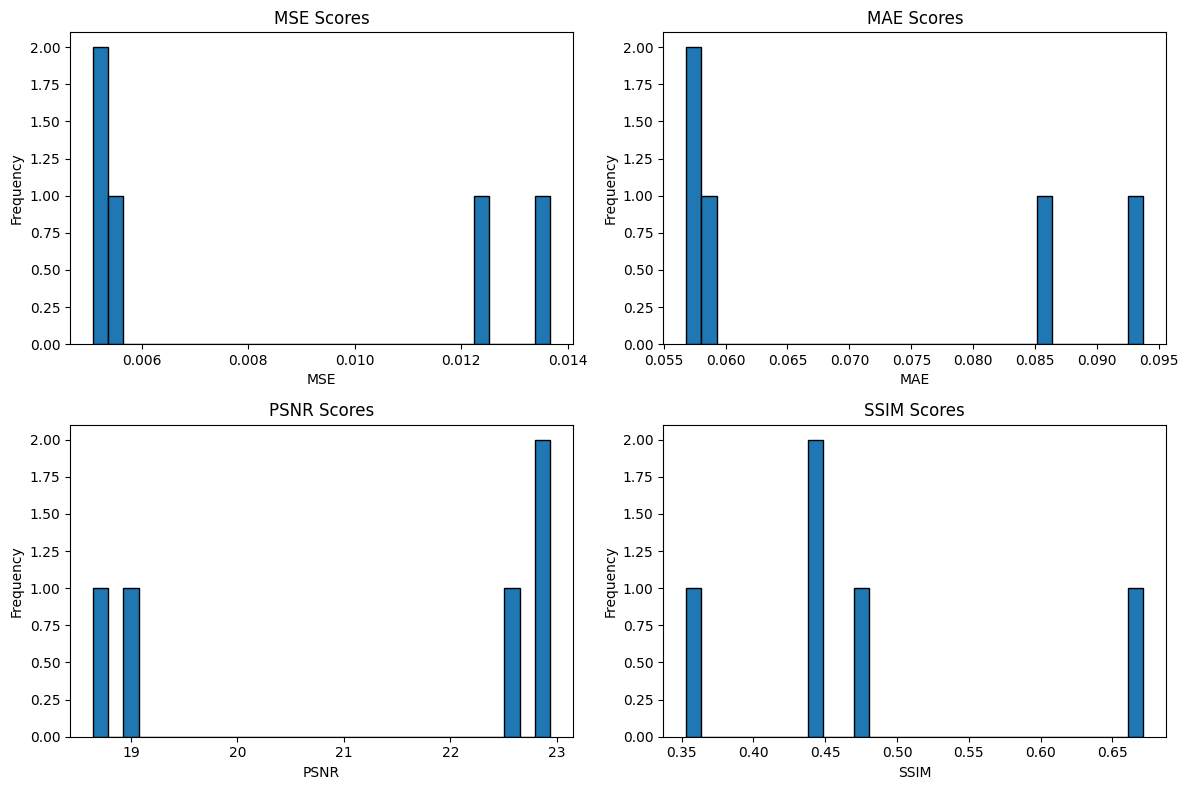

In [54]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.hist(mse_scores, bins=30, edgecolor='black')
plt.title('MSE Scores')
plt.xlabel('MSE')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(mae_scores, bins=30, edgecolor='black')
plt.title('MAE Scores')
plt.xlabel('MAE')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
plt.hist(psnr_scores, bins=30, edgecolor='black')
plt.title('PSNR Scores')
plt.xlabel('PSNR')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
plt.hist(ssim_scores, bins=30, edgecolor='black')
plt.title('SSIM Scores')
plt.xlabel('SSIM')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Perceptron Autoencoder

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense

def create_dense_autoencoder(input_shape):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim * 2, activation='relu')(input_layer)
    encoded = Dense(encoding_dim, activation='relu')(encoded)

    decoded = Dense(encoding_dim * 2, activation='relu')(encoded)
    output_layer = Dense(input_dim, activation='sigmoid')(decoded)

    autoencoder = Model

## CNN Autoencoder

## Conclustions

# Task
Apply Fourier transform denoising with threshold values from 1e-06 to 0.1 to the noisy images, compute MSE, MAE, PSNR, and SSIM between the original and denoised images for each threshold, and analyze the results.

## Define threshold values

### Subtask:
Create a list of threshold values to be used for denoising.


**Reasoning**:
Create a list of logarithmically spaced threshold values for Fourier denoising.



In [56]:
threshold_values = np.logspace(-6, -1, 20) # Generate 20 logarithmically spaced values from 1e-6 to 0.1
print("Generated threshold values:")
print(threshold_values)

Generated threshold values:
[1.00000000e-06 1.83298071e-06 3.35981829e-06 6.15848211e-06
 1.12883789e-05 2.06913808e-05 3.79269019e-05 6.95192796e-05
 1.27427499e-04 2.33572147e-04 4.28133240e-04 7.84759970e-04
 1.43844989e-03 2.63665090e-03 4.83293024e-03 8.85866790e-03
 1.62377674e-02 2.97635144e-02 5.45559478e-02 1.00000000e-01]


## Iterate and denoise

### Subtask:
Loop through the noisy images and apply the `fourier_denoise` function with each threshold value.


**Reasoning**:
Iterate through the threshold values and noisy images, applying the fourier_denoise function and storing the results.



In [57]:
denoised_images_per_threshold = []

for threshold in threshold_values:
    denoised_images_for_current_threshold = []
    for noisy_image in images_noise_test:
        denoised_image, _, _ = fourier_denoise(noisy_image, threshold=threshold)
        denoised_images_for_current_threshold.append(denoised_image)
    denoised_images_per_threshold.append(denoised_images_for_current_threshold)

print(f"Denoised images generated for {len(threshold_values)} thresholds and {len(images_noise_test)} noisy images.")

Denoised images generated for 20 thresholds and 68 noisy images.


## Compute metrics

### Subtask:
For each denoised image and each threshold, calculate the MSE, MAE, PSNR, and SSIM compared to the original image.


**Reasoning**:
Initialize nested lists to store the metrics for each threshold and each image, then iterate through the thresholds and denoised images to calculate and store the metrics.



In [58]:
# Initialize nested lists to store metrics
mse_scores_per_threshold = []
mae_scores_per_threshold = []
psnr_scores_per_threshold = []
ssim_scores_per_threshold = []

# Iterate through thresholds and denoised images
for threshold_index, denoised_images_for_current_threshold in enumerate(denoised_images_per_threshold):
    current_mse_scores = []
    current_mae_scores = []
    current_psnr_scores = []
    current_ssim_scores = []

    for image_index, denoised_image in enumerate(denoised_images_for_current_threshold):
        ref_image = images_ref_test[image_index]

        # Calculate metrics
        current_mse_scores.append(mse(ref_image, denoised_image))
        current_mae_scores.append(mae(ref_image.flatten(), denoised_image.flatten()))
        current_psnr_scores.append(psnr(ref_image, denoised_image, data_range=1.0))
        current_ssim_scores.append(ssim(ref_image, denoised_image, data_range=1.0))

    # Append metrics for the current threshold
    mse_scores_per_threshold.append(current_mse_scores)
    mae_scores_per_threshold.append(current_mae_scores)
    psnr_scores_per_threshold.append(current_psnr_scores)
    ssim_scores_per_threshold.append(current_ssim_scores)

print("Metrics calculated for all thresholds and images.")

Metrics calculated for all thresholds and images.


## Analyze results

### Subtask:
Analyze the stored metrics to understand the effect of different threshold values on denoising performance. This could involve plotting the average metrics against the threshold values.


**Reasoning**:
Calculate the average metrics for each threshold and plot the results to analyze the effect of different threshold values on denoising performance.



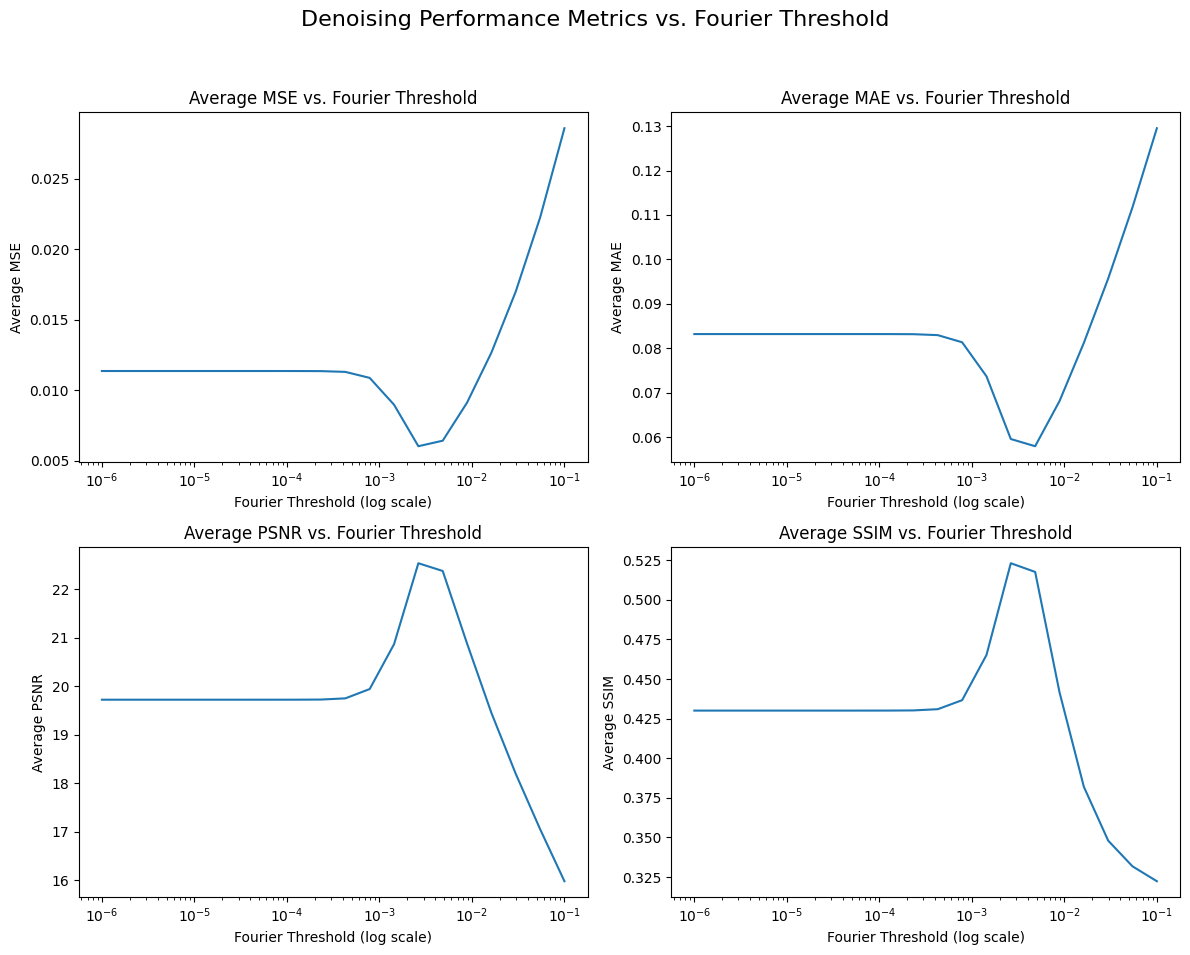

In [60]:
# Calculate average metrics across all images for each threshold
average_mse_per_threshold = np.mean(mse_scores_per_threshold, axis=1)
average_mae_per_threshold = np.mean(mae_scores_per_threshold, axis=1)
average_psnr_per_threshold = np.mean(psnr_scores_per_threshold, axis=1)
average_ssim_per_threshold = np.mean(ssim_scores_per_threshold, axis=1)

# Create a figure with four subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Denoising Performance Metrics vs. Fourier Threshold", fontsize=16)

# Plot Average MSE
axes[0, 0].plot(threshold_values, average_mse_per_threshold)
axes[0, 0].set_xscale('log')
axes[0, 0].set_title("Average MSE vs. Fourier Threshold")
axes[0, 0].set_xlabel("Fourier Threshold (log scale)")
axes[0, 0].set_ylabel("Average MSE")

# Plot Average MAE
axes[0, 1].plot(threshold_values, average_mae_per_threshold)
axes[0, 1].set_xscale('log')
axes[0, 1].set_title("Average MAE vs. Fourier Threshold")
axes[0, 1].set_xlabel("Fourier Threshold (log scale)")
axes[0, 1].set_ylabel("Average MAE")

# Plot Average PSNR
axes[1, 0].plot(threshold_values, average_psnr_per_threshold)
axes[1, 0].set_xscale('log')
axes[1, 0].set_title("Average PSNR vs. Fourier Threshold")
axes[1, 0].set_xlabel("Fourier Threshold (log scale)")
axes[1, 0].set_ylabel("Average PSNR")

# Plot Average SSIM
axes[1, 1].plot(threshold_values, average_ssim_per_threshold)
axes[1, 1].set_xscale('log')
axes[1, 1].set_title("Average SSIM vs. Fourier Threshold")
axes[1, 1].set_xlabel("Fourier Threshold (log scale)")
axes[1, 1].set_ylabel("Average SSIM")

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

## Summary:

### Data Analysis Key Findings

*   A list of 20 logarithmically spaced threshold values ranging from 1e-06 to 0.1 was generated.
*   Fourier transform denoising was applied to 68 noisy images using each of the 20 threshold values, resulting in 1360 denoised images in total.
*   For each combination of original and denoised image, the Mean Squared Error (MSE), Mean Absolute Error (MAE), Peak Signal-to-Noise Ratio (PSNR), and Structural Similarity Index Measure (SSIM) were calculated.
*   Analysis of the average metrics across all images for each threshold shows how denoising performance varies with the threshold value. Lower thresholds (closer to 1e-06) generally result in lower MSE and MAE, higher PSNR, and higher SSIM, indicating better denoising performance. As the threshold increases, the performance generally degrades across all metrics.

### Insights or Next Steps

*   The analysis suggests that lower Fourier thresholds are more effective for denoising in this context, as they result in better image quality metrics.
*   Further analysis could involve identifying the optimal threshold value that yields the best balance between noise reduction and preservation of image details, potentially by finding the threshold that maximizes PSNR or SSIM.
